In [26]:
import pandas as pd

df = pd.read_csv('data.csv')  # read df from csv file

df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d-%m-%Y %H;%M:%S')
df = df.drop(columns=['Date', 'Time'])
df.set_index('Datetime', inplace=True)

# using month and hour as features
df['Month'], df['Hour']  = df.index.month, df.index.hour 

df.describe()

,Load,Month,Hour
count,527040.000000,527040.000000,527040.000000
mean,1.091538,6.513661,11.500000
std,1.107404,3.451237,6.922193
min,0.076000,1.000000,0.000000
25%,0.294000,4.000000,5.750000
50%,0.548000,7.000000,11.500000
75%,1.530000,10.000000,17.250000
max,10.162000,12.000000,23.000000


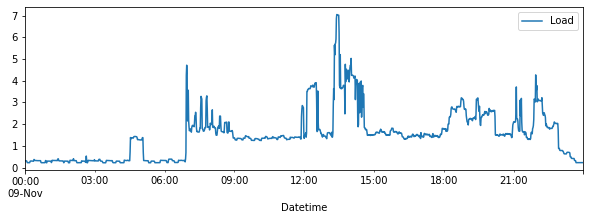

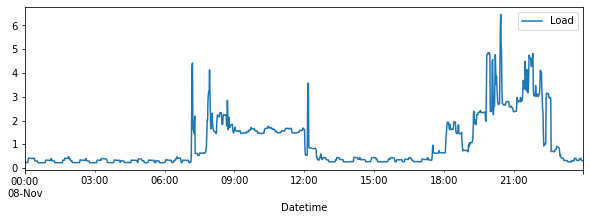

In [27]:
target_date=['2007-11-09', '2007-11-08']

def plot_data(df, target_date):
    for tar in target_date:
        one_day_data = df.loc[tar]
        one_day_data.plot(y='Load', figsize=(10, 3))

plot_data(df, target_date)

In [28]:
import numpy as np
import torch
from nn_model import *

device="cuda"

# # preprocessing
# for col in ['Month', 'Hour']:
#     df[col] = (df[col] - df[col].mean()) / df[col].std()

n_train = int(len(df) * 0.8)
train_features = torch.tensor(df.iloc[:n_train, 1:].values, dtype=torch.float32, device=device)
test_features = torch.tensor(df.iloc[n_train:, 1:].values, dtype=torch.float32, device=device)
train_labels = torch.tensor(df.iloc[:n_train, 0].values.reshape(-1, 1), dtype=torch.float32, device=device)
test_labels = torch.tensor(df.iloc[n_train:, 0].values.reshape(-1, 1), dtype=torch.float32, device=device)

In [35]:
from torch.utils.data import Dataset, DataLoader

class Plant_Dataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, index):
        return self.features[index], self.labels[index]
    
plant_dataset = Plant_Dataset(train_features, train_labels)
plant_dataloader = DataLoader(plant_dataset, batch_size=36, shuffle=False)

In [36]:
plant_model = Plant_Model()
num_epochs = 3
for epoch in range(num_epochs):
    for batch_idx, (features, labels) in enumerate(plant_dataloader):
        loss = plant_model.update(features, labels)
    print(loss)

tensor(2.2836, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(3.1304, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(3.1342, device='cuda:0', grad_fn=<MseLossBackward0>)


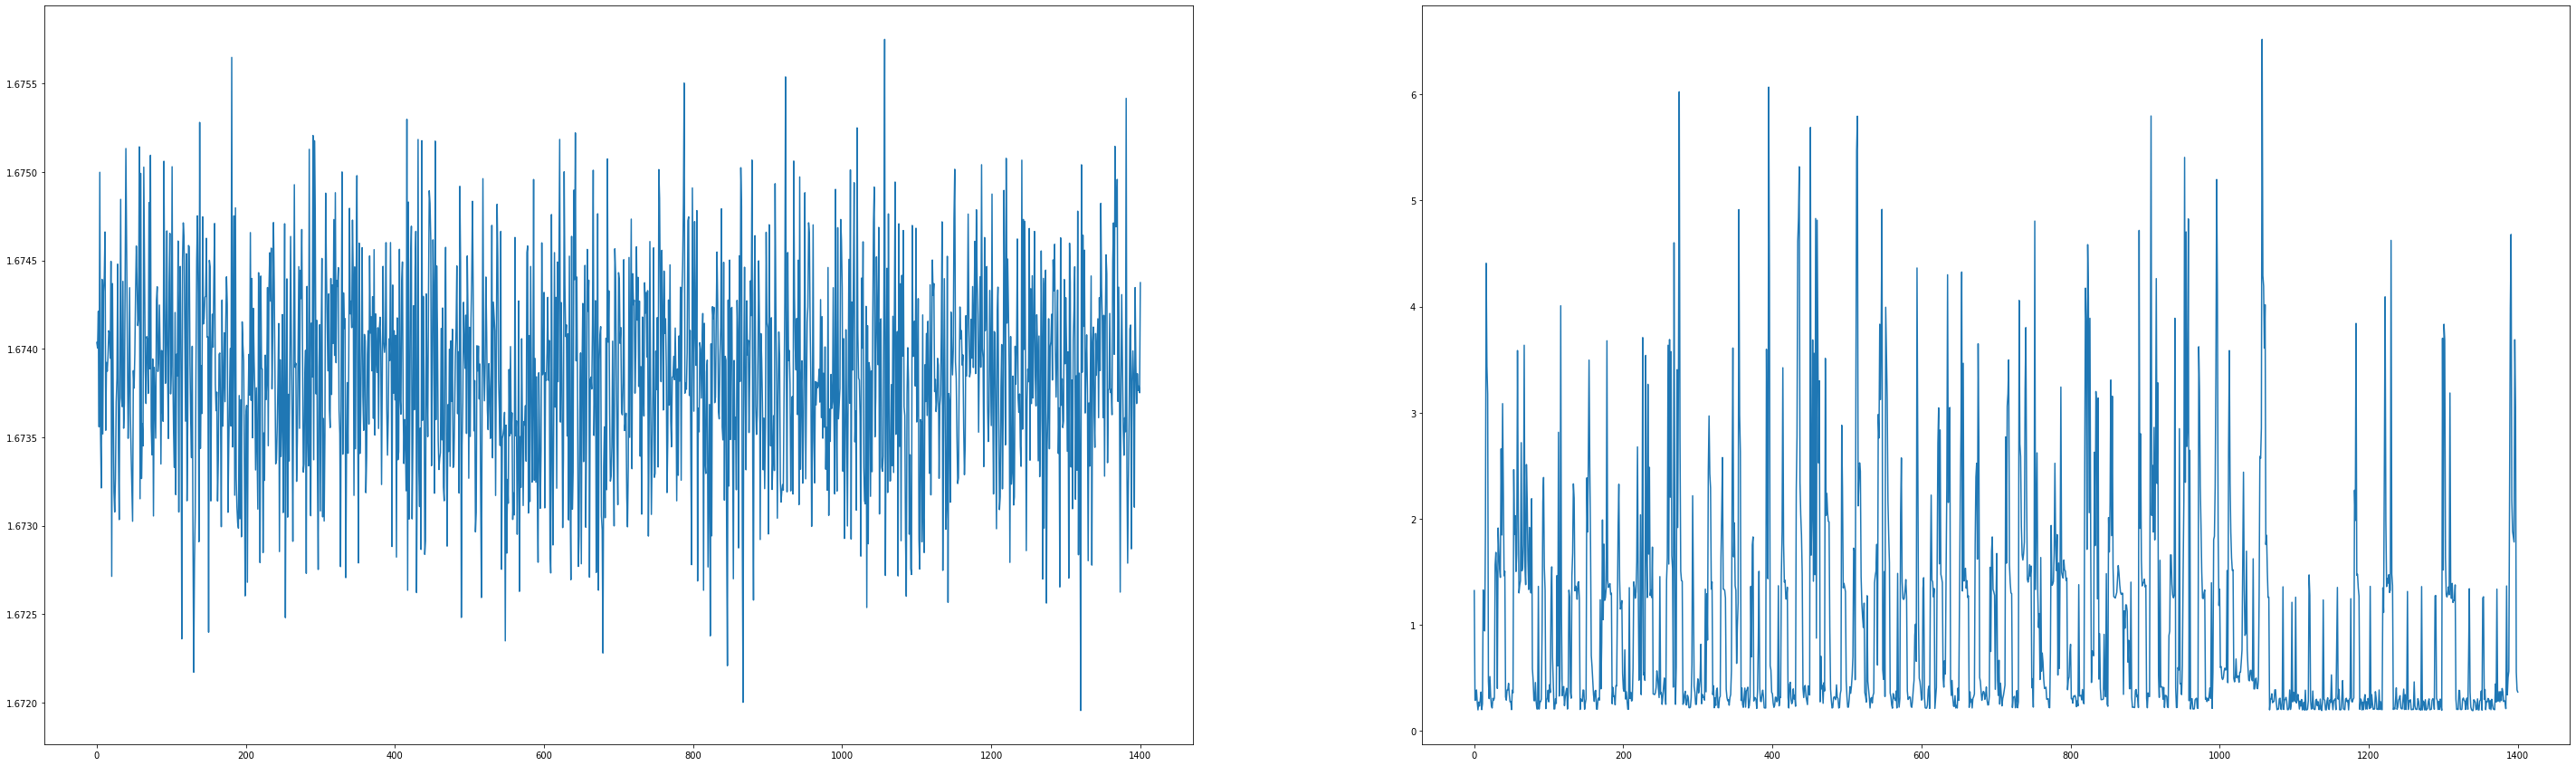

In [37]:
import matplotlib.pyplot as plt
count = 0
out_vals = []
ground_truth = []

for batch_idx, (features, labels) in enumerate(plant_dataloader):
    ground_truth.append(labels.tolist()[0])
    output = plant_model.transition_step(features)
    out_vals.append(output.tolist()[0])
    count += 1
    if count > 1400:
        break    

steps = np.arange(0, count)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(15)
fig.set_figwidth(50)
ax1.plot(steps, out_vals, label='Predicted')
ax2.plot(steps, ground_truth, label='Actual')